# Load data

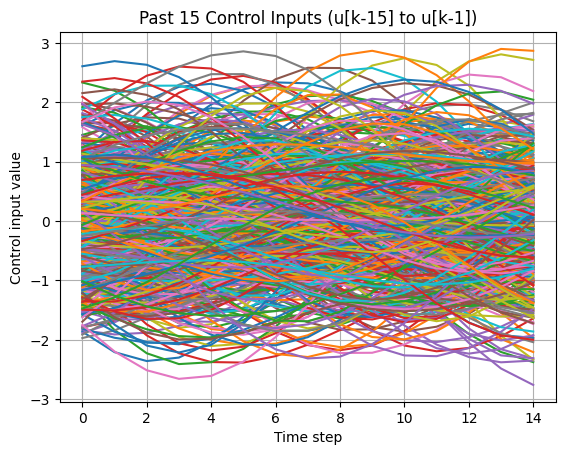

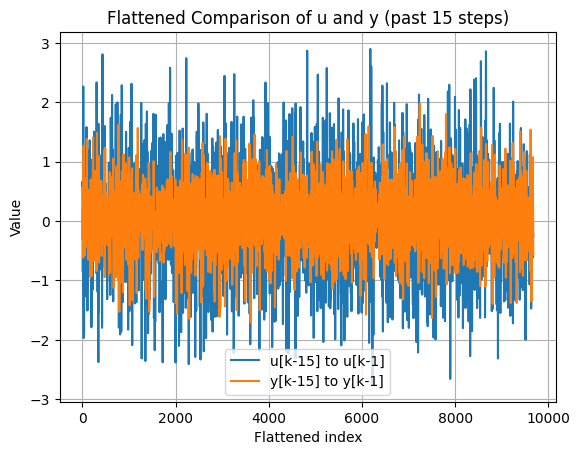

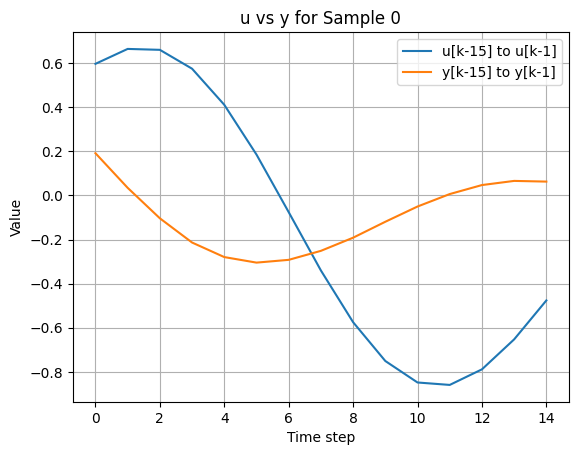

In [1]:
import numpy as np
import os
import scipy.io
import sys
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared

out = np.load('training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('hidden-test-prediction-submission-file.npz')
upast_test = data['upast'] #N by u[k-15],u[k-14],...,u[k-1]
thpast_test = data['thpast'] #N by y[k-15],y[k-14],...,y[k-1]

# Plot all 15 columns of u
plt.figure()
plt.plot(upast_test.T)  # Transpose so each column (time step) is a separate line
plt.title('Past 15 Control Inputs (u[k-15] to u[k-1])')
plt.xlabel('Time step')
plt.ylabel('Control input value')
plt.grid(True)
plt.show()

# Plot u and y together (flattened for comparison)
plt.figure()
plt.plot(upast_test.flatten(), label='u[k-15] to u[k-1]')
plt.plot(thpast_test.flatten(), label='y[k-15] to y[k-1]')
plt.title('Flattened Comparison of u and y (past 15 steps)')
plt.xlabel('Flattened index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(upast_test[0], label='u[k-15] to u[k-1]')
plt.plot(thpast_test[0], label='y[k-15] to y[k-1]')
plt.title('u vs y for Sample 0')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


## Create the function f

In [2]:

def f(upast,ypast):
    ukm2, ukm1 = upast
    ykm2, ykm1 = ypast
    ystar = (0.8 - 0.5 * np.exp(-ykm1 ** 2)) * ykm1 - (0.3 + 0.9 * np.exp(-ykm1 ** 2)) * ykm2 \
           + ukm1 + 0.2 * ukm2 + 0.1 * ukm1 * ukm2
    return ystar + np.random.normal(scale=0.01)

def use_NARX_model_in_simulation(ulist, f, na, nb):
    #init upast and ypast as lists.
    upast = [0]*nb 
    ypast = [0]*na 
    
    ylist = []
    for unow in ulist:
        #compute the current y given by f
        ynow = f(upast,ypast) 
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result

na, nb = 2, 2

np.random.seed(42)
N = 500
ulist = upast_test.T[1] #u[k-15] to u[k-1]
ylist = thpast_test.T[1] #y[k-15] to y[k-1]

def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata), np.array(Ydata)

split = 0.75 #75% training and 25% validation split
split_index = int(len(ulist)*split) 
Xtrain, Ytrain = make_training_data(ulist[:split_index],ylist[:split_index], na, nb) 
Xval,   Yval   = make_training_data(ulist[split_index:],ylist[split_index:], na, nb)
print('Xtrain.shape',Xtrain.shape)
print('Xval.shape',Xval.shape)

Xtrain.shape (481, 4)
Xval.shape (160, 4)


## Fitting


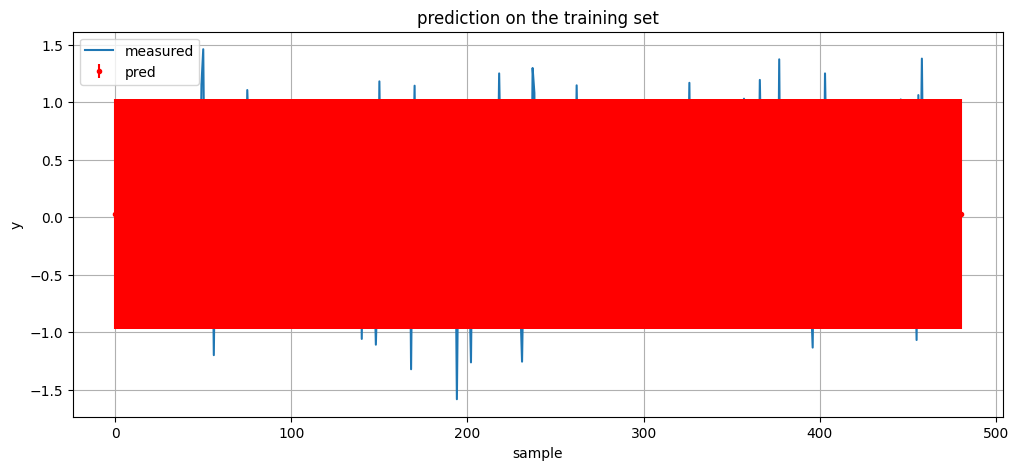

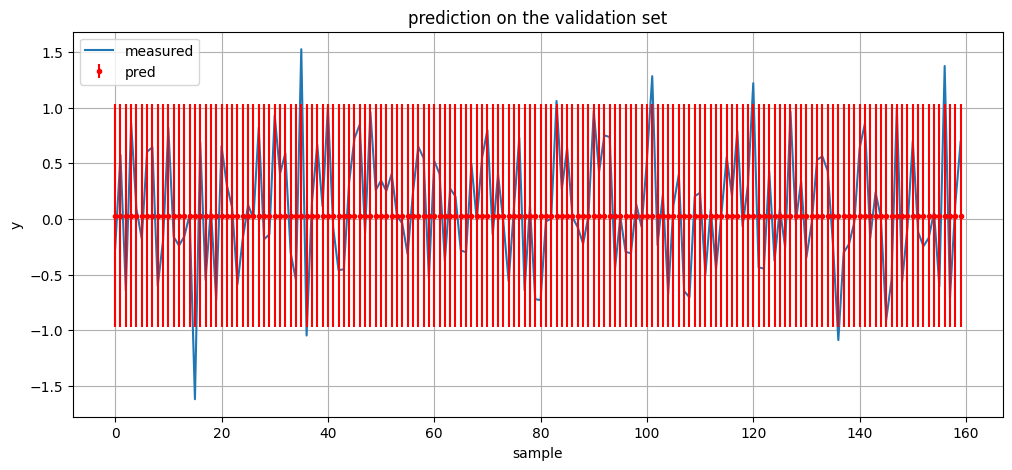

Validation NRMS= 1.007980386792488


In [3]:
ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) #a=)
reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) #a=)
reg.fit(Xtrain,Ytrain) #a)

#residual calculations and plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) #a)
plt.figure(figsize=(12,5)) #a)
plt.plot(Ytrain) #a)
plt.title('prediction on the training set')
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) #a)
plt.errorbar(np.arange(len(Xtrain)), (Ytrain_pred), yerr=2*Ytrain_pred_std,fmt='.r') #a)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])#a)
plt.show() #a)

plt.figure(figsize=(12,5)) #a)
plt.title('prediction on the validation set')
plt.plot(Yval) #a)
Yval_pred, Yval_pred_std = reg.predict(Xval,return_std=True) #a)
plt.errorbar(np.arange(len(Xval)), (Yval_pred), yerr=2*Yval_pred_std,fmt='.r') #a)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred']) #a)
plt.show() #a)

print(f'Validation NRMS= {np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)}')#a)

## Try new kernal

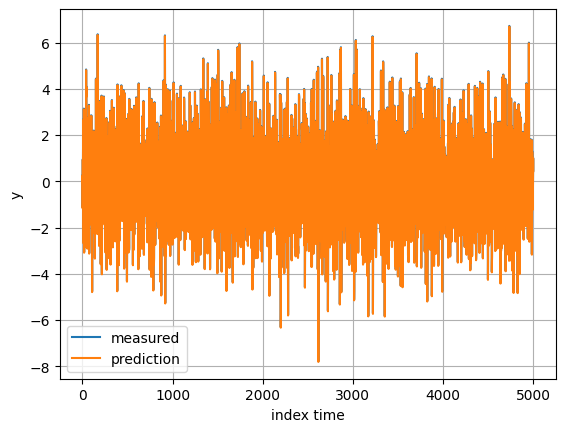

NRMS= 1.0000158682250646


In [4]:
np.random.seed(43)
utest = np.random.normal(scale=1.0,size=5000)
ytest = use_NARX_model_in_simulation(utest,f,na,nb)


model_now = reg #b=)
fmodel = lambda u,y: model_now.predict(np.concatenate([u,y])[None,:])[0] 
ytest_sim = use_NARX_model_in_simulation(utest, fmodel, na, nb)
plt.plot(ytest) #b)
plt.plot(ytest-ytest_sim) #b)
plt.grid(); plt.xlabel('index time'); plt.ylabel('y'); plt.legend(['measured','prediction']) #b)
plt.show() #b)

print('NRMS=',np.mean((ytest-ytest_sim)**2)**0.5/np.std(ytest)) #b)
